In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# For reproducible random results.
np.random.seed(789)

# The following utility functions are provided for your convenience.
# You may use them in your solution, or you may write your own.
# Do not alter them, and please read the docstrings carefully.
K = np.array([[471.14628085,  -4.94771211, 295.13159043], [0., 436.71106326, 240.96582594], [0., 0., 1.]])
SQUARE_SIZE = 0.0205

## Problem 1.1

(63,)


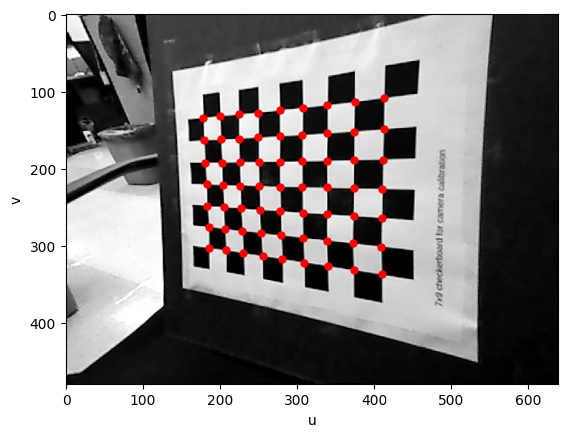

[409.75568 373.57596 339.7811  309.51093 280.6833  255.1641  230.38338
 207.98706 185.57394 409.21014 372.34335 338.6659  307.65433 279.29675
 253.26137 228.57938 206.30377 185.11617 410.2782  373.32935 338.55518
 307.21747 278.45435 251.67528 226.95935 204.83652 183.45502 410.52704
 373.34225 338.6454  306.46765 277.78802 250.60614 226.43892 203.53061
 182.52428 411.51886 373.7152  338.43982 306.71164 277.4174  250.06833
 225.50269 202.58739 180.83925 412.43665 373.88052 339.26328 306.6644
 277.5493  249.9327  224.57268 201.41019 178.89783 412.98163 374.63184
 339.55084 307.38382 277.34042 249.93289 224.28601 200.0143  178.50212]


In [3]:
# Read the image from file
img_path = "p1_data/checkerboard.png"
image = cv2.imread(img_path, 0)

# Plot Corners on top of image
fig = plt.figure()
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_ylabel("v")
ax.set_xlabel("u")

# 1) Find the corner locations of the chessboard in image space.
#    Hint: Use the function cv2.findChessboardCorners(image, (num_corners_x, num_corners_y))
#    Hint: findChessboardCorners outputs pixel coordinates!
# 2) Plot their location in image space over top of the image.
#    Hint: use ax.plot(...) -- should be one line!
#    Hint: This should only be 1 line of code!

ncorners_y = 7
ncorners_x = 9
# --------- YOUR CODE STARTS HERE ---------------
corner_locations = cv2.findChessboardCorners(image, (ncorners_x, ncorners_y))
corner_array = corner_locations[1]
u = corner_array[:, 0, 0]
v = corner_array[:, 0, 1]
print(u.shape)
ax.plot(u, v, 'ro', markersize = 5)
plt.savefig('Qn_1A.png')
plt.show()
# --------- YOUR CODE ENDS HERE -----------------

## Problem 1.2

In [74]:
# 1)  Compute the homography, H.
#     1.a) Use the SQUARE_SIZE, and the dimensions of the grid above to
#             to create a the array P = [[X_0, Y_0, 1], .... [X_n, Y_n, 1]].
#             P should have shape (63, 3).
#          Hint: Use np.meshgrid to generate the X, Y coordinates, and
#             array.reshape and np.hstack to form the final matrix.
#     1.b) Form the M matrix outlined in the write-up!
#     1.c) Use np.linalg.svd(M) to solve for the nullspace of M and recover H.
#          Hint: np.linalg.svd(M) returns V.T.
#          Hint: Use <array>.reshape(3, 3) to give H the proper dimensions.
# 2)  Compute the camera pose rotation, R, and translation, t.
#     2.a) Compute KinvH = inv(K) @ H.
#          Hint: Use np.linalg.inv().
#     2.b) Normalize the values of KinvH to it's first column.
#          Hint: Use np.linalg.norm() and the / operator.
#     2.c) Compute r0, r1, r2, and t as outlined in the write-up.
#          Hint: Use np.cross().
#     2.d) Form R from r0, r1, and r2.
#          Hint: Use np.column_stack()

# --------- YOUR CODE STARTS HERE ---------------
# Generating World Frame Coordinates and meshgriding them:
x_coord = np.arange(ncorners_x) * SQUARE_SIZE
y_coord = np.arange(ncorners_y) * SQUARE_SIZE
X, Y = np.meshgrid(x_coord, y_coord)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
ones = np.ones_like(X).reshape(-1, 1)
# Generating P Matrix:
P = np.hstack((X, Y, ones))

# Gnerating Matrix M:
num_rows = (P.shape[0] * 2) 
num_columns = 9
M = np.zeros((num_rows, num_columns))
for i in range(P.shape[0]):
    M[2*i, :] = np.array([0, 0, 0, -X[i][0], -Y[i][0], -1, v[i] * X[i][0], v[i] * Y[i][0], v[i]])
    M[2*i+1, :] = np.array([-X[i][0], -Y[i][0], -1, 0, 0, 0, u[i] * X[i][0], u[i] * Y[i][0], u[i]])

# Part 1c:
U, S, Vt = np.linalg.svd(M)
# Step 2: Extract the nullspace vector (smallest singular value)
null_vector = Vt[-1]
# Step 3: Reshape the null vector to obtain the homography matrix H
H = null_vector.reshape(3, 3)

# 2)  Compute the camera pose rotation, R, and translation, t.
#     2.a) Compute KinvH = inv(K) @ H.
KinvH = np.linalg.inv(K) @ H

#     2.b) Normalize the values of KinvH to it's first column.
scaling_factor = np.linalg.norm(KinvH[:, 0])
KinvH /= scaling_factor

# 2.c) Compute r0, r1, r2, and t
r0 = KinvH[:, 0]
r1 = KinvH[:, 1]
r2 = np.cross(r0, r1)
t = KinvH[:, 2]

print(t)
# 2.d) Form R from r0, r1, and r2
R = np.column_stack((r0, r1, r2))
print(R)
# --------- YOUR CODE ENDS HERE -----------------

[0.06041666 0.05504642 0.24836523]
[[-0.84159518 -0.02457411  0.55448957]
 [-0.04607233 -1.01948989 -0.12028731]
 [ 0.53814022 -0.12721435  0.85686559]]


## Problem 1.3

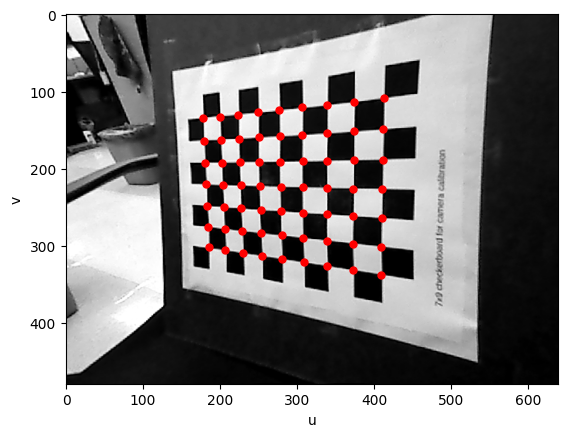

In [89]:
# 1) Finish the transform_world_to_camera function which uses
#       the given K, and the R and t that you calculated!.
#    Hint: You'll need to use some equations from the write-up.

def transform_world_to_camera(K, R, t, world_coords):
    """
    Args:
        K: np.array with shape (3, 3), camera intrinsics matrix.
        R: np.array with shape (3, 3), camera rotation.
        t: np.array with shape (3, ) or (3, 1), camera translation.
        world_coords: np.array with shape (N, 3), cartesian coordinates (X, Y, Z)
            in world frame to transform into camera pixel space.
    Return:
        uv: np.array with shape (N, 2), with (u, v) coordinates of that are
            the projections of the the world_coords on the image plane.
    """
    # --------- YOUR CODE STARTS HERE ---------------
    camera_coords = R @ world_coords.T + t.reshape(-1, 1)
    uvw = K @ camera_coords
    uv = (uvw[:2] / uvw[2]).T
    # --------- YOUR CODE ENDS HERE -----------------
    return uv

ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")
ax.plot(uv[:, 0], uv[:, 1], 'ro', markersize = 5)


# 2) Project the global coordinates of the corners that you calculated
#       earlier back onto the image using transform_world_to_camera.
#    Hint: The input world_coords should have shape (63, 3)
#    Hint: Use the Xs and Ys you got earlier and set Zs = 0.
#    Hint: You may need to change some of the variable names at the bottom
#       of this cell to match the names that you used above!

# --------- YOUR CODE STARTS HERE ---------------
world_coords = np.zeros((63, 3))
for i in range(63):
    world_coords[i, :] = np.array([X[i][0], Y[i][0],  0])

uv = transform_world_to_camera(K, R, t, world_coords)
# --------- YOUR CODE ENDS HERE -----------------

## Project Anything!
Try using your the camera pose you computed to project our secret point cloud (defined in world coordinates) onto the camera frame!

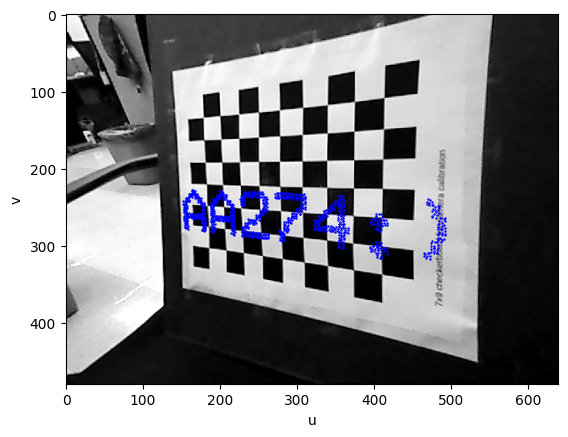

In [88]:
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# Load the secrect point cloud from file!
point_cloud_secret = np.load("p1_data/secret.npy")

# NOTE: Uncomment the lines below when you've finished everything else!
uv_secret = transform_world_to_camera(K, R, t, point_cloud_secret)
ax.scatter(uv_secret[:, 0], uv_secret[:, 1], s=0.5, c="b")